In [2]:
### imports 
import pandas as pd
import seaborn as sns
import sys
import ast

sys.path.append('../')
sys.path.append('../src')

from src.datahandling.loading import load_data
from src.datahandling.preprocessing import *
from src.models.ma import MovingAverage
from src.models.regression import RidgeRegression
from src.models.xgb import XGB
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import Nystroem
# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

### load benchmarks
benchmarks = pd.read_csv("../results/benchmarks.csv")
benchmarks_braz = list(benchmarks["MAE"][3:]) + list(benchmarks["RMSE"][3:])
benchmarks_brit = list(benchmarks["MAE"][:3]) + list(benchmarks["RMSE"][:3])

# Evaluation - Notebook

Within this document, we carry out a comparison of the implemented models:

1. Moving Average
2. Two Variants of Linear Regression
3. XGBoost Regressor

Please find the hyperparameter tuning and comments on the transfer learning challenge of the models in their respective notebook.
At the end of this notebook, you find an overall conclusion for the entire project.

In [3]:
### define models
models = {
    "ma": Pipeline(
        [
            ("st", SupervisedTransformer()),
            ("ma", MovingAverage()),
        ]
    ),
    "rr": Pipeline(
        [
            ("scale", Normalizer()),
            ("st", SupervisedTransformer(encode_time=["hour", "month"])),
            ("est", RidgeRegression()),
        ]
    ),
    "kernel": Pipeline(
        [
            ("scale", Normalizer()),
            ("st", SupervisedTransformer(encode_time=["hour", "month"])),
            ("nystroem", Nystroem(n_jobs=-1)),
            ("est", RidgeRegression()),
        ]
    ),
    "xgb": Pipeline(
        [
            ("norm", Normalizer()),
            ("st", SupervisedTransformer(encode_time=["hour", "month"])),
            ("xgb", XGB()),
        ]
    ),
}

## British Dataset - Kelmarsh

In [4]:
### loading data
TURBINE_ID = 2
data_brit = load_data(turbine_id=TURBINE_ID, which_data="British")

### cleaning data
cleaner = DataCleaner(
    features=[
        "Power (kW)",
        "Wind speed (m/s)",
        "Wind direction (°)",
        "Nacelle position (°)",
        "Nacelle ambient temperature (°C)",
        "Rotor speed (RPM)",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "nacelle_position",
        "nacelle_temp",
        "rotor_speed",
    ],
)
data_brit = cleaner.transform(data_brit)

# create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][0]
test_end = benchmarks["test_end"][0]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_brit, test_start=test_start, test_end=test_end, target_var="power"
)

In [5]:
### load results and best parameters
gs_results = {}
best_params = {}

for key in models.keys():
    gs_results[key] = pd.read_csv(f"../results/results_gs_{key}_braz.csv")
    best_params[key] = (
        gs_results[key]
        .set_index(["params"])[["mean_test_score", "param_st__horizon"]]
        .groupby("param_st__horizon")
        .idxmax()
    )

In [6]:
### calculate metrics for each model and horizon
Metrics = ["MAE", "RMSE"]
Horizons = ["10min", "hourly", "daily"]
# create multiindex for results dataframe
idx = pd.MultiIndex.from_product([Metrics, Horizons], names=["Metric", "Horizon"])
results_brit = pd.DataFrame(index=idx, columns=models.keys())

for key in models.keys():
    print(key)
    for horizon in Horizons:
        # load best model for horizon
        best_model = models[key].set_params(
            **ast.literal_eval(best_params[key].loc[horizon][0])
        )
        # fit model
        best_model.fit(X_train, y_train)
        # predict
        y_pred = best_model.predict(X_test)
        # calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        # save results
        results_brit.loc[("MAE", horizon), key] = mae
        results_brit.loc[("RMSE", horizon), key] = rmse

ma
rr
kernel
xgb
[14:39:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:41:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


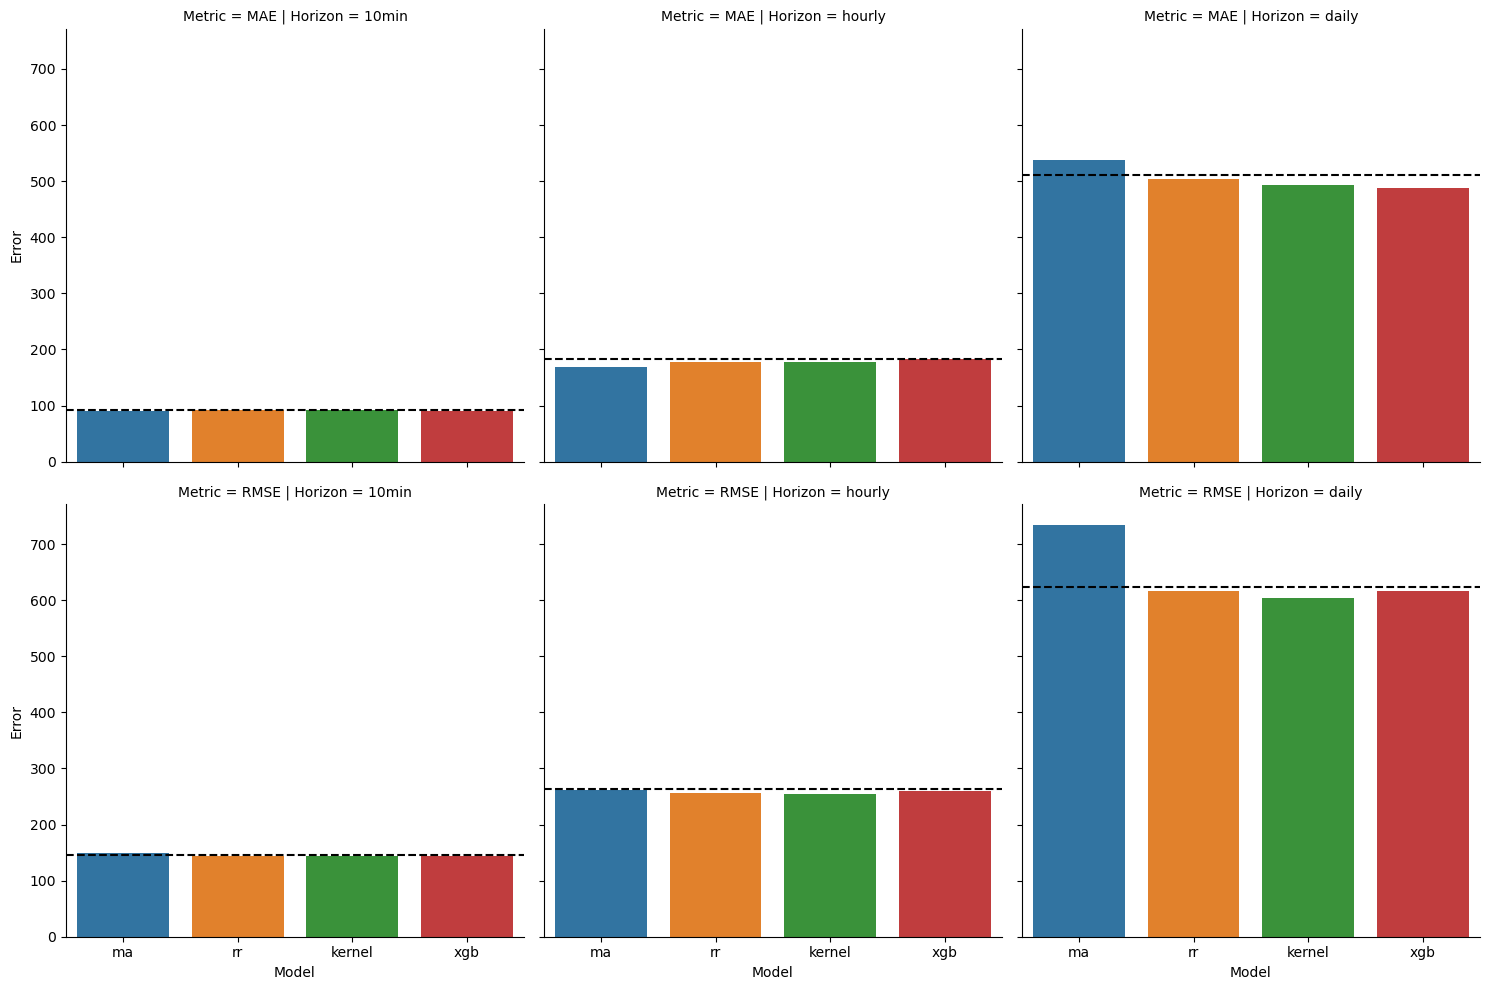

In [7]:
### plot results
df = pd.melt(
    results_brit.reset_index(),
    id_vars=["Metric", "Horizon"],
    value_vars=models.keys(),
    var_name="Model",
    value_name="Error",
)
fg = sns.catplot(df, x="Model", y="Error", col="Horizon", row="Metric", kind="bar")

for i, ax in enumerate(fg.axes.flat):
    ax.axhline(benchmarks_brit[i], ls="--", color="black")

__Analysis__:

Most models show superior performance compared to both of the benchmarks, with the exception being the _Moving Average_ model, which falls short when it comes to daily forecasting. This is especially noteworthy for the MAE metric since hyperparameter tuning was performed with respect to the RMSE.

The two regression variations and the _XGB_ model exhibit comparable error rates, all slightly surpassing the benchmark in all cases. 
In conclusion, we would advise considering the _Ridge Regression_ model as the top choice due to its computational efficiency and its ability to provide interpretable parameters. Furthermore, it demonstrates robustness with regard to its hyperparameters within this setting (see corresponding notebook).

## Brazilian Dataset - Beberibe

In [8]:
### loading data
TURBINE_ID = 1
data_braz = load_data(turbine_id=TURBINE_ID, which_data="Brazilian")

### cleaning data
cleaner = DataCleaner(
    features=[
        "active_power_total",
        "wind_speed",
        "wind_direction",
        "rotor_rpm",
        "air_density",
        "relative_humidity",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "rotor_speed",
        "air_density",
        "relative_humidity",
    ],
)
data_braz = cleaner.transform(data_braz)

# create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][3]
test_end = benchmarks["test_end"][3]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_braz, test_start=test_start, test_end=test_end, target_var="power"
)

In [9]:
### load results and best parameters
gs_results = {}
best_params = {}

for key in models.keys():
    gs_results[key] = pd.read_csv(f"../results/results_gs_{key}_braz.csv")
    best_params[key] = (
        gs_results[key]
        .set_index(["params"])[["mean_test_score", "param_st__horizon"]]
        .groupby("param_st__horizon")
        .idxmax()
    )

In [10]:
### calculate metrics for each model and horizon
Metrics = ["MAE", "RMSE"]
Horizons = ["10min", "hourly", "daily"]
# create multiindex for results dataframe
idx = pd.MultiIndex.from_product([Metrics, Horizons], names=["Metric", "Horizon"])
results = pd.DataFrame(index=idx, columns=models.keys())

for key in models.keys():
    print(key)
    for horizon in Horizons:
        # load best model for horizon
        best_model = models[key].set_params(
            **ast.literal_eval(best_params[key].loc[horizon][0])
        )
        # fit model
        best_model.fit(X_train, y_train)
        # predict
        y_pred = best_model.predict(X_test)
        # calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        # save results
        results.loc[("MAE", horizon), key] = mae
        results.loc[("RMSE", horizon), key] = rmse

ma
rr
kernel
xgb
[14:48:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


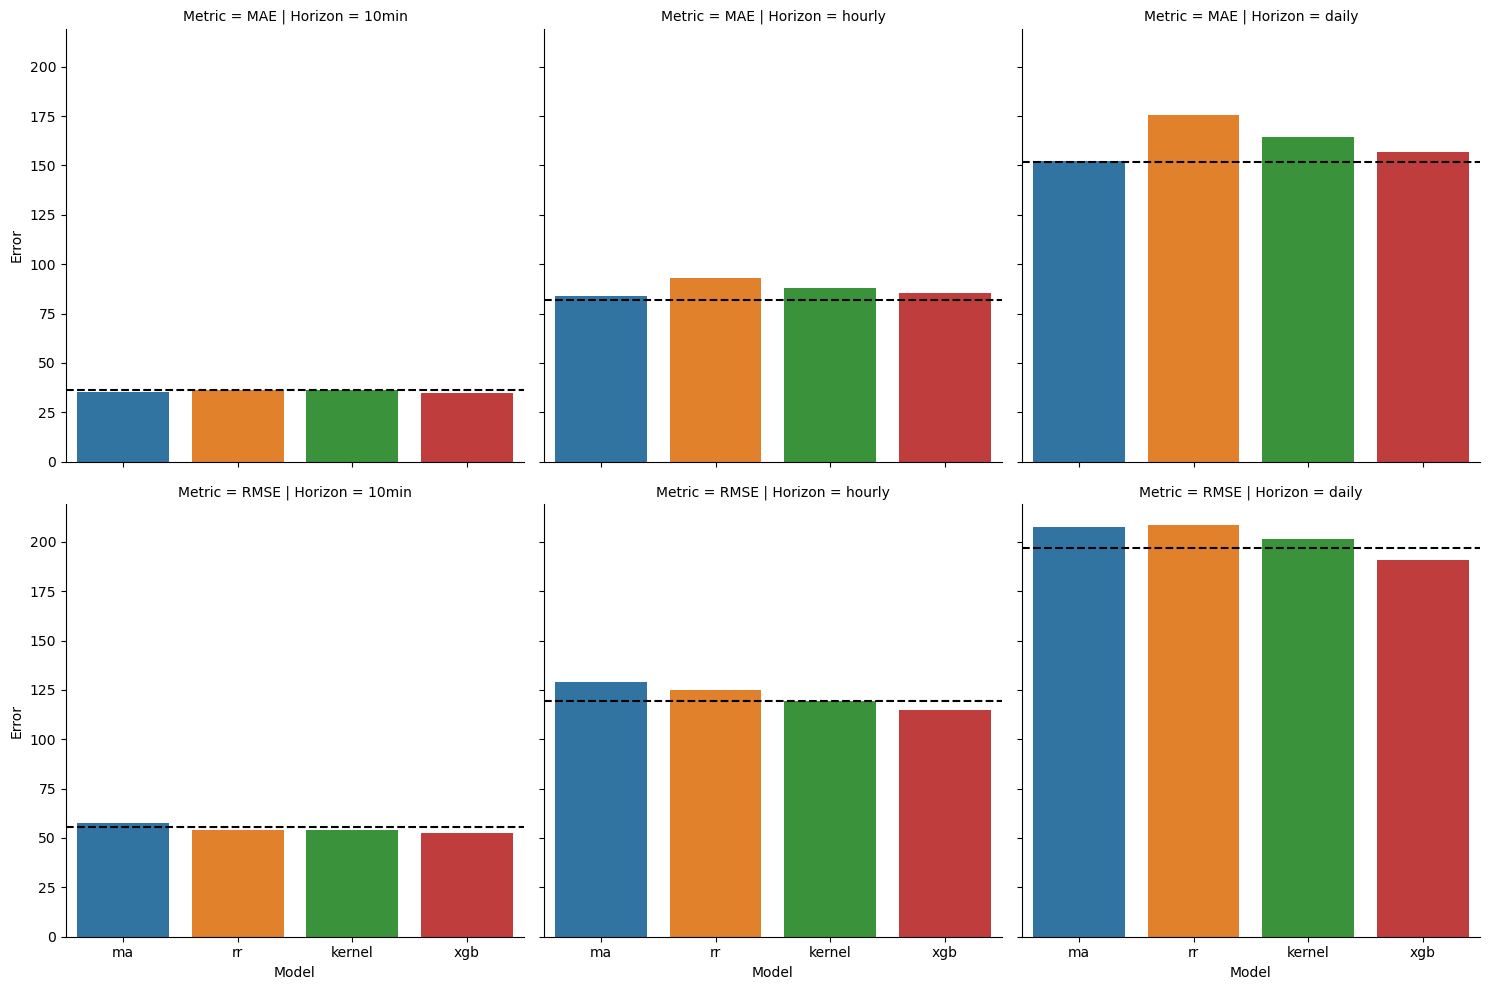

In [11]:
### plot results
df = pd.melt(
    results.reset_index(),
    id_vars=["Metric", "Horizon"],
    value_vars=models.keys(),
    var_name="Model",
    value_name="Error",
)
fg = sns.catplot(df, x="Model", y="Error", col="Horizon", row="Metric", kind="bar")

for i, ax in enumerate(fg.axes.flat):
    ax.axhline(benchmarks_braz[i], ls="--", color="black")

__Analysis__:

Considering the Brazilian dataset, we notice that only the _XGB_ model consistently outperforms the RMSE benchmarks across all scenarios. All other models struggle to surpass the benchmarks. When it comes to daily forecasting, the gap between between the regression variants and the benchmarks is the most pronounced.

In conclusion, we state that the _XGB_ model is the best choice for this dataset.

# Overall Conclusion

In this project, we have implemented and evaluated four different models for time series forecasting of the power output of a wind turbine. Datasets of a British and Brazilian wind farms were discussed.

Using the same __implementation__ scheme as the estimators and transformers in sklearn yielded compatibility with the pipeline and grid search functionality of sklearn. This allowed us to perform hyperparameter tuning and cross-validation in a straightforward manner.

The __Moving Average__ model is the simplest model implemented. It just considers past values of the target variable to predict into the future. It is therefore computationally cheap and easy to interpret. However, it suffers from a strong time lag in its predictions, resulting in the fact that in almost every the benchmarks could not be beaten. Hyperparameter tuning yields a very straight forward rule of thumb for the window size to choose: It should be in the same order of magnitude as the forecasting horizon.

The __Ridge Regression__ model is also a computationally cheap model. It provides interpretable parameters and seems to be very robust with regard to its hyperparameters. Employing it on the British datasets yields an improvement to the benchmarks. However, the same result could not be observed for the Brazilian datasets.

__Kernel Regression__ and __XGB__ are computationally much more costly than the previous two. The _XGB_ model outperforms the benchmarks in almost all tasks across both datasets. The _Kernel Regression_ model is able to beat the benchmarks in the British dataset, but not in the Brazilian dataset. In both cases, we needed to make computational trade-offs to make the model feasible to use on our hardware. For _Kernel Regression_, we had to approximate the kernel matrix using a subset of the training data. Results could be improved by using a more powerful machine. For _XGB_, we had to employ randomness to explore the hyperparameter space in a feasible amount of time. Using better hardware could result in better insights on the optimal hyperparameters.

Overall we state that the _Ridge Regression_ and _XGB_ models are the best choices for the task at hand. _Ridge Regression_ is the best choice if computational efficiency and interpretability are important. _XGB_ is the best choice if the best possible performance across all datasets is desired. 

In this project, our focus is solely on the examination of supervised learning approaches. However, potential future endeavors might involve exploring purely time series-driven techniques like SARIMA. Additionally, we could explore deep learning approaches, with Long Short-Term Memory networks (LSTMs) being a suitable architecture for handling time series data. Moreover, considering our transformation of the data into a supervised learning problem, we could also consider the use of a straightforward Multi-Layer Perceptron (MLP).

For the __transfer learning challenge__ the trick seems to be to normalize every feature and targets to make them comparable across datasets. This yields satisfying visual results across all models that need to infer parameters/coefficients. Also with respect to the error metrics MAE and RMSE the results are reasonably. Mention should be made here that the _Moving Average_ model solves this challenge by design, since it is only considering past values of the target variable and does not need to infer any parameters. Altogether, we state that the _transfer learning challenge_ was successful.